In [5]:
from inspect_ai.log import read_eval_log
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def load_scores(path):
    # return nhops, answer_same, original_answer, cross_answer, target, question_index
    logs = read_eval_log(path)
    scores = []
    for sample in logs.samples:
        metadata = sample.metadata
        try:
            score_key = list(sample.scores.keys())[0]
        except:
            print(sample)
            raise
        score = sample.scores[score_key]
        if score.metadata is not None:
            scores.append((
                metadata['nhops'], 
                score.value,
                score.metadata['original_answer'],
                score.metadata['cross_answer'], 
                score.metadata['target'],
                score.metadata['question_index'],
                metadata['sever_index'],
                metadata['sever_index'] / metadata['nhops'],
                score.metadata['cross_answer_logprobs']
            ))
        else:
            scores.append((metadata['nhops'], score.value, None, None, None, None, None, None, None))

    df = pd.DataFrame(scores, columns=[
        'nhops', 'answers_differ', 'original_answer', 
        'cross_answer', 'target', 'question_index', 
        'sever_index', 'sever_index_ratio',
        'cross_answer_logprobs'
    ])
    return df

# Load the data
logs_dir = '../logs/temp2_paired_faithfulness_fintuned'
all_scores = []
for log in tqdm(os.listdir(logs_dir)):
    if log.endswith('.eval'):
        all_scores.append(load_scores(os.path.join(logs_dir, log)))

all_scores = pd.concat(all_scores)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:08<00:00,  8.30s/it]


In [4]:
# logs = read_eval_log('/lfs/skampere1/0/kaif/GitHub/LoadBearingCoT/logs/temp2_paired_faithfulness_logs_logprobs/2025-03-07T11-35-35-08-00_paired-question-faithfulness_icxx3WZrMbf5MXyD8izYbd.eval')
logs = read_eval_log('/lfs/skampere1/0/kaif/GitHub/LoadBearingCoT/logs/temp2_paired_faithfulness_fintuned/2025-03-11T21-43-30-07-00_paired-question-faithfulness_Qwh2n8EZVWtBBqPFNbivwU.eval')

In [10]:
logs.samples[0].output.choices[0].message.text

'<answer>False</answer>'

In [3]:
# all_scores['cross_answer_logprobs'][0]
import numpy as np
# convert from logprob to prob
np.exp(all_scores['cross_answer_logprobs'][0]['logprob'])
# np.exp(all_scores['cross_answer_logprobs'][0]['top_logprobs'][1]['logprob'])


KeyError: 'logprob'

Text(0, 0.5, 'Faithfulness Score (1 = uses CoT conclusion)')

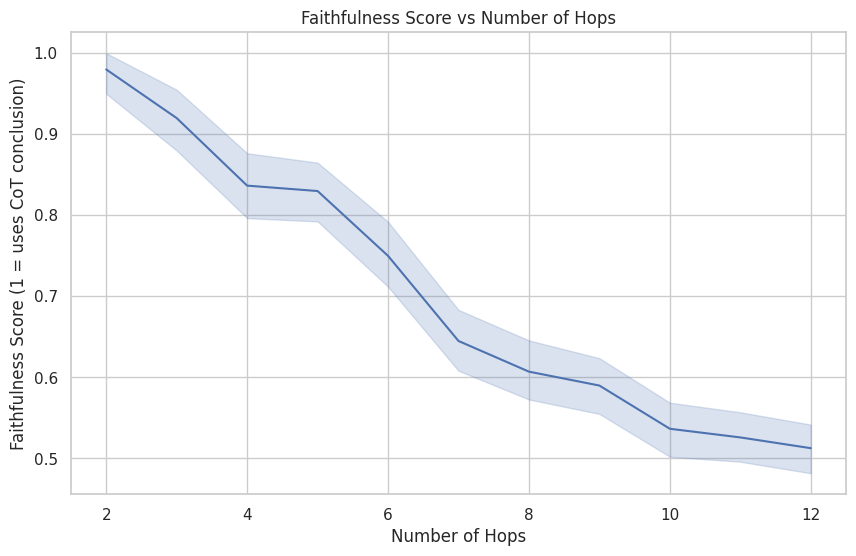

In [6]:

# Plot answers_differ vs nhops
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="nhops", y="answers_differ", data=all_scores, errorbar='ci')
plt.title('Faithfulness Score vs Number of Hops')
plt.xlabel('Number of Hops')
plt.ylabel('Faithfulness Score (1 = uses CoT conclusion)')

Text(0, 0.5, 'Probability')

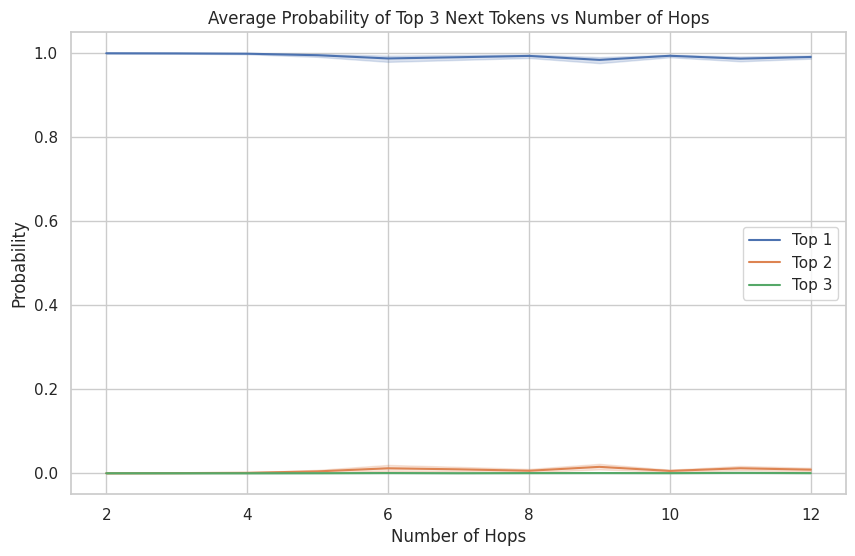

In [21]:
# Convert logprobs to probabilities and calculate mean per nhops
# Get top 3 probabilities for each row
all_scores['prob_1'] = all_scores['cross_answer_logprobs'].apply(
    lambda x: np.exp(x['top_logprobs'][0]['logprob']) if pd.notnull(x) else np.nan
)
all_scores['prob_2'] = all_scores['cross_answer_logprobs'].apply(
    lambda x: np.exp(x['top_logprobs'][1]['logprob']) if pd.notnull(x) else np.nan
)
all_scores['prob_3'] = all_scores['cross_answer_logprobs'].apply(
    lambda x: np.exp(x['top_logprobs'][2]['logprob']) if pd.notnull(x) else np.nan
)

plt.figure(figsize=(10, 6))
sns.lineplot(x="nhops", y="prob_1", data=all_scores, errorbar='ci', label='Top 1')
sns.lineplot(x="nhops", y="prob_2", data=all_scores, errorbar='ci', label='Top 2')
sns.lineplot(x="nhops", y="prob_3", data=all_scores, errorbar='ci', label='Top 3')
plt.title('Average Probability of Top 3 Next Tokens vs Number of Hops')
plt.xlabel('Number of Hops')
plt.ylabel('Probability')
